# CNN Demo

## Computing Environment Setup
TO DO: add a CoLab badge

In [1]:
PC_SEQUENCES=1000
NC_SEQUENCES=1000
BASES=55
ALPHABET=4
INPUT_SHAPE_2D = (BASES,ALPHABET,1) #2D inputs
INPUT_SHAPE = (BASES,ALPHABET) #1D inputs
FILTERS = 8
WIDTH = 3
STRIDE_2D = (1,1)
STRIDE = 1
EPOCHS=5  # use 5 for software testing, 50 for model testing
SPLITS=5
FOLDS=1  # max = num splits


In [2]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/blob/main/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  # delete the file later?
except:
    print("On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs

On my PC, use relative paths.


In [3]:
from os import listdir
import time # datetime
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense,Embedding
from keras.layers import Conv1D,Conv2D
from keras.layers import Flatten,MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

from SimTools.RNA_gen import *
if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")

## Data Preparation

In [4]:
# print(datetime.datetime.now())
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-06 15:16:36 EDT'

In [5]:
def get_all_sequences():
    cgen = Collection_Generator()
    sgen = Sequence_Oracle()
    lgen = Length_Oracle()
    lgen.set_mean(BASES)
    cgen.set_seq_oracle(sgen)
    cgen.set_len_oracle(lgen)
    sgen.set_frequencies([3,0,0,3]) # bias AT
    pc_seqs=cgen.get_sequences(PC_SEQUENCES)
    sgen.set_frequencies([1,1,1,1]) # bias GT
    nc_seqs=cgen.get_sequences(NC_SEQUENCES)
    return pc_seqs,nc_seqs
pc_seqs,nc_seqs = get_all_sequences()

In [6]:
def prepare_for_learning(pcs,ncs):
    samples = nc_seqs + pc_seqs
    NUM_SAMPLES=len(samples)
    X_shape = (NUM_SAMPLES,BASES,ALPHABET)
    Y_shape = (NUM_SAMPLES,1)
    y=np.concatenate((np.zeros(NC_SEQUENCES,dtype=np.int8),
                      np.ones(PC_SEQUENCES,dtype=np.int8)))
    X=np.zeros(X_shape,dtype=np.int8)
    base_to_dim = {'A':0, 'C':1, 'G':2, 'T':3}
    for s in range(0,NUM_SAMPLES):  # TO DO: speed this up by avoiding loops
        sample = samples[s]
        for b in range(0,BASES): # use len(sample) if length varies
            base = sample[b]
            d = base_to_dim[base]   # TO DO: error on non-ACGT
            X[s,b,d]=1
    X,y = shuffle(X,y,random_state=4200)
    return X,y
X,y = prepare_for_learning(pc_seqs,nc_seqs)
print("X shape:",X.shape)
print("y shape:",y.shape)


X shape: (2000, 55, 4)
y shape: (2000,)


## Model build, train, test

In [7]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=4,output_dim=4)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,
                  padding="same",input_shape=INPUT_SHAPE))
    # Data shape: [SAMPLES,BASES,FILTERS]
    #dnn.add(MaxPooling1D())
    dnn.add(Flatten())
    # Data shape: [SAMPLES,BASES*FILTERS]
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',loss=BinaryCrossentropy(from_logits=False))
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (55, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 55, 8)             104       
_________________________________________________________________
flatten (Flatten)            (None, 440)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 441       
Total params: 545
Trainable params: 545
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    splitter = KFold(n_splits=SPLITS)  # no shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # use iloc[] for dataframe
            y_train=y[train_index]
            X_valid=X[valid_index]
            y_valid=y[valid_index]        
            # Avoid continually improving the same model.
            print("MODEL")
            model = model = make_DNN()
            #bestname=MODEL_FILE+".cv."+str(fold)+".best"
            #mycallbacks = [keras.callbacks.ModelCheckpoint(
            #    filepath=bestname, save_best_only=True, 
            #    monitor='val_accuracy', mode='max')]   
            print("FIT")
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, verbose=1) # callbacks=mycallbacks,
                    ## validation_data=(X_valid,y_valid))
            # THE VALIDATION ABOVE IS JUST FOR SHOW
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
            #best_model=keras.models.load_model(bestname)
            # THE VALIDATION BELOW IS FOR KEEPS
            #scores = best_model.evaluate(X_VALID, Y_VALID, verbose=0)
            #print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
            #cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

MODEL
make_DNN
input shape: (55, 4)
FIT
Epoch 1/5
50/50 [==============================] - 1s 2ms/step - loss: 0.6298
Epoch 2/5
50/50 [==============================] - 0s 2ms/step - loss: 0.2307
Epoch 3/5
50/50 [==============================] - 0s 2ms/step - loss: 0.0548
Epoch 4/5
50/50 [==============================] - 0s 3ms/step - loss: 0.0228
Epoch 5/5
50/50 [==============================] - 0s 2ms/step - loss: 0.0128
Fold 1, 5 epochs, 1 sec


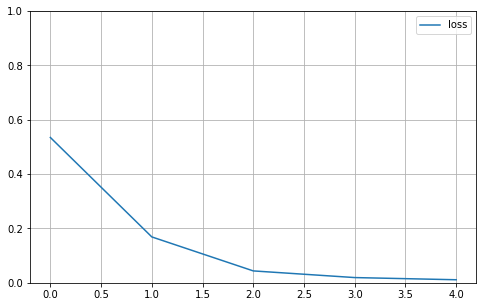


1-way Cross Validation mean nan% (+/- nan%)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret

In [9]:
do_cross_validation(X,y)

Full shape received: (32, 55, 2, 10)
    
ValueError: No gradients provided for any variable: ['conv1d_5/kernel:0', 'conv1d_5/bias:0', 'dense_5/kernel:0', 'dense_5/bias:0'].